# 悪性URL検出
## 訓練データ
(url文字列, whois情報,悪性かどうかの二値)が与えられる。

## 前処理
- whoisの中身を列に追加
- url文字列、whois情報をエンコーディングする  

ある頻度以上の文字のみ残して、各文字に番号を割り振る  
文字列のインデックスごとで特徴量を分割  





In [ ]:
pip install xgboost

In [ ]:
# Googleドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

%cd /content/drive/My Drive/Colab Notebooks

import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


# 前処理

In [ ]:
# csvの中身 (列がなぜか大量に追加されていたので削除)
import pandas as pd

data_path = "processed_whois40000.csv"
df = pd.read_csv(data_path)
print(df.columns.tolist())
column_position = df.columns.get_loc('country') # country以降を削除
print(f"The 'country' column is at position {column_position}")

df = df.iloc[:, :21]
print(df.iloc[:10, :20])

<ipython-input-3-45d71cb37489>:5: DtypeWarning: Columns (33,34,35,41,44,45,47,48,57,59,60,64,69,74,88,89,90,91,92,93,94,95,96,98,102,108,109,110,114,115,116,117,118,125,127,128,132,139,146,147,148,149,150,151,152,154) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


['url', 'type', 'whois_data', 'domain_name', 'registrar', 'whois_server', 'referral_url', 'updated_date', 'creation_date', 'expiration_date', 'name_servers', 'status', 'emails', 'dnssec', 'name', 'org', 'address', 'city', 'state', 'registrant_postal_code', 'country', 'registrant_name', 'registrant_id', 'owner_c', 'admin_c', 'tech_c', 'billing_c', 'name_server', 'nsstat', 'nslastaa', 'saci', 'nic_hdl_br', 'person', 'email', 'phone', 'fax', 'registrar_address', 'registrar_postal_code', 'registrar_city', 'registrar_country', 'registrar_url', 'registrant_number', 'admin_name', 'registrant_organization', 'registrant_address', 'admin_address', 'admin_organization', 'tech_address', 'tech_organization', 'tech_name', 'registrar_name', 'registrant_type', 'registrant_street', 'registrant_city', 'registrant_country', 'country_code', 'registrar_email', 'registrant_state', 'registrant_email', 'registrant_phone', 'registrant_fax', 'admin', 'admin_country', 'admin_city', 'admin_state', 'admin_email', 

In [ ]:
# 'label'列の追加 benign(良性)のものは0, それ以外(悪性)のものは1を付与
df['label'] = df['type'].apply(lambda x: 0 if x == 'benign' else 1)

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

# DataFrameから'referral_url', 'type'列を削除
df = df.drop("referral_url", axis=1)
df = df.drop("type", axis=1)


# DataFrameからNaNを含む行を削除
df = df.dropna()
print(df)

# 学習の短時間化のため1000件使う
df_head = df.head(2000)

print("良性url: ", len(df_head[df_head["label"] == 0]))
print("悪性url: ", len(df_head[df_head["label"] == 1]))

# 特徴量とラベルの分離
X = df_head.drop(columns=["label"])  # 特徴量
y = df_head["label"]  # ラベル

                                                     url  \
1                    mp3raid.com/music/krizz_kaliko.html   
6          espn.go.com/nba/player/_/id/3457/brandon-rush   
7         yourbittorrent.com/?q=anthony-hamilton-soulife   
9          allmusic.com/album/crazy-from-the-heat-r16990   
10     corporationwiki.com/Ohio/Columbus/frank-s-bens...   
...                                                  ...   
39978       facebook.com/people/Dolores-Riley/1841225709   
39991                              facebook.com/oguertin   
39992   abebooks.com/book-search/author/a-benoit/signed/   
39996                           facebook.com/bowman.stan   
39998              maseeh1.tripod.com/advices7/id193.htm   

                                              whois_data  \
1      {\n  "domain_name": "MP3RAID.COM",\n  "registr...   
6      {\n  "domain_name": [\n    "GO.COM",\n    "go....   
7      {\n  "domain_name": [\n    "YOURBITTORRENT.COM...   
9      {\n  "domain_name": "ALLMUSIC.CO

In [ ]:
"""
from collections import Counter

def encoder(df, max_len: int = 100, min_freq: int = 2):
    char2idx: list[dict[str, int]] = []

    i=0
    for col in df.columns:
        print(f"Define {col} as the {i}-th element of char2idx")
        combined_text = ''.join(df[col].astype(str))
        counter = Counter(combined_text)
        # 各列colに対して、文字と番号の設定
        char2idx[i] = {char: idx for idx, (char, freq) in enumerate(counter.items()) if freq >= min_freq}
        i = i+1

    # 数値に変換
    i=0
    for col in df.columns:  # すべての列に対して
        for j in range(len(df)):  # すべてのデータを数値に
            row_j = df[col].iloc[j]

            data_list = []
            for k, char in enumerate(row_j[:max_len]):
                data_list[k] = char2idx[i].get(char, 0)  # 未知の文字は0にマッピング
            df[col].iloc[j] = data_list

        i = i+1  # char2idxを更新
    return df, char2idx

processed_df = encoder(df_head)[0]
"""



In [ ]:
"""
# encoderのIndexError修正版
from collections import Counter

def encoder(df, max_len: int = 100, min_freq: int = 2):
    char2idx: list[dict[str, int]] = []

    for i, col in enumerate(df.columns):
        print(f"Define {col} as the {i}-th element of char2idx")
        combined_text = ''.join(df[col].astype(str))
        counter = Counter(combined_text)
        char2idx.append({char: idx for idx, (char, freq) in enumerate(counter.items()) if freq >= min_freq})

    for i, col in enumerate(df.columns):
        for j in range(len(df)):
            row_j = df[col].iloc[j]
            data_list = []
            for k, char in enumerate(str(row_j)[:max_len]):
                data_list.append(char2idx[i].get(char, 0))
            df[col].iloc[j] = data_list

    return df, char2idx

processed_df = encoder(df_head)[0]
"""


In [ ]:
"""
# encoderのIndexError修正版
from collections import Counter

def encoder(df, max_len: int = 100, min_freq: int = 2):
    char2idx: list[dict[str, int]] = []

    for i, col in enumerate(df.columns):
        print(f"Define {col} as the {i}-th element of char2idx")
        combined_text = ''.join(df[col].astype(str))
        counter = Counter(combined_text)
        char2idx.append({char: idx for idx, (char, freq) in enumerate(counter.items()) if freq >= min_freq})

    for i, col in enumerate(df.columns):
        for j in range(len(df)):
            row_j = df[col].iloc[j]
            data_list = []
            for k, char in enumerate(str(row_j)[:max_len]):
                data_list.append(char2idx[i].get(char, 0))
            df[col].iloc[j] = data_list

    return df, char2idx

processed_df = encoder(df_head)[0]
"""

In [ ]:
# dfの要素の不具合の修正
import numpy as np
from collections import Counter

def encoder(df, max_len: int = 100, min_freq: int = 2):
    char2idx: list[dict[str, int]] = []

    for i, col in enumerate(df.columns):
        print(f"Define {col} as the {i}-th element of char2idx")
        combined_text = ''.join(df[col].astype(str))
        counter = Counter(combined_text)
        char2idx.append({char: idx for idx, (char, freq) in enumerate(counter.items()) if freq >= min_freq})

    new_data = []

    for i, col in enumerate(df.columns):
        col_data = []
        for j in range(len(df)):
            row_j = df[col].iloc[j]
            data_list = []
            for k, char in enumerate(str(row_j)[:max_len]):
                data_list.append(char2idx[i].get(char, 0))
            col_data.append(data_list)
        new_data.append(col_data)

    return pd.DataFrame(np.array(new_data).T, columns=df.columns), char2idx

processed_X, char2idx = encoder(X)

# リスト内の各要素を個別の特徴として扱う
expanded_data = []
for col in processed_X.columns:
    # pandasのapply関数を使用して各リストをpd.Seriesに変換し、それを新しいデータフレームの列として展開
    expanded_col = processed_X[col].apply(pd.Series)
    expanded_col = expanded_col.rename(lambda x: f"{col}_{x}", axis=1)
    expanded_data.append(expanded_col)

# すべての展開されたデータフレームを横に連結
processed_X = pd.concat(expanded_data, axis=1)


Define url as the 0-th element of char2idx
Define whois_data as the 1-th element of char2idx
Define domain_name as the 2-th element of char2idx
Define registrar as the 3-th element of char2idx
Define whois_server as the 4-th element of char2idx
Define updated_date as the 5-th element of char2idx
Define creation_date as the 6-th element of char2idx
Define expiration_date as the 7-th element of char2idx
Define name_servers as the 8-th element of char2idx
Define status as the 9-th element of char2idx
Define emails as the 10-th element of char2idx
Define dnssec as the 11-th element of char2idx
Define name as the 12-th element of char2idx
Define org as the 13-th element of char2idx
Define address as the 14-th element of char2idx
Define city as the 15-th element of char2idx
Define state as the 16-th element of char2idx
Define registrant_postal_code as the 17-th element of char2idx
Define country as the 18-th element of char2idx


<ipython-input-6-07369743a85a>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return pd.DataFrame(np.array(new_data).T, columns=df.columns), char2idx


In [ ]:

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import metrics
import time

X_train, X_test, y_train, y_test = train_test_split(processed_X, y, test_size=0.3)
model = XGBClassifier(n_estimators=10)

start_time = time.time()
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

loss = metrics.log_loss(y_test, y_pred_proba)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='binary')
recall = metrics.recall_score(y_test, y_pred, average='binary')

print(f'Loss: {loss}, Accuracy: {accuracy:.3f}, Precision: {precision:.5f}, Recall: {recall:.5f}')

end_time = time.time()
print(f'学習時間:  {end_time - start_time} seconds')


[0]	validation_0-logloss:0.46273
[1]	validation_0-logloss:0.33291
[2]	validation_0-logloss:0.25128
[3]	validation_0-logloss:0.19605
[4]	validation_0-logloss:0.15887
[5]	validation_0-logloss:0.13043
[6]	validation_0-logloss:0.11231
[7]	validation_0-logloss:0.09974
[8]	validation_0-logloss:0.09111
[9]	validation_0-logloss:0.08388
Loss: 0.08388023805365084, Accuracy: 0.982, Precision: 0.97368, Recall: 0.89157
学習時間:  1.4463796615600586 seconds


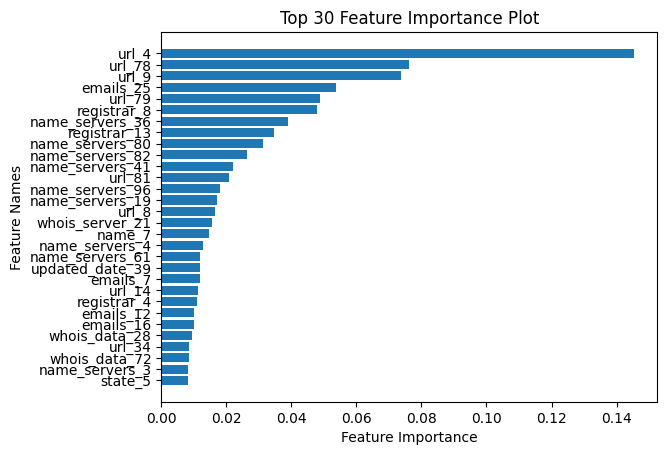

In [ ]:
import matplotlib.pyplot as plt

# 特徴量とその重要度を一緒に取得
features = list(processed_X.columns)
importances = model.feature_importances_

# 重要度に基づいて特徴量と重要度を一緒にソート
indices = np.argsort(importances)

# トップ20の特徴量とその重要度を取得
top_features = np.array(features)[indices][-30:]
top_importances = importances[indices][-30:]

# 重要度が高い特徴量から低い特徴量への順でプロット
plt.barh(top_features, top_importances)

# グラフのラベルとタイトルを設定
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Top 30 Feature Importance Plot')

# グラフを表示
plt.show()



url_4はURLの5文字目の重要度、みたいになっているはず。

## url_ で始まる列のみを使用して学習する

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import metrics
import time

# "url_" で始まる列のみを使用
URL_columns = [col for col in processed_X.columns if col.startswith('url_')]
X_URL_only = processed_X[URL_columns]

X_train, X_test, y_train, y_test = train_test_split(X_URL_only, y, test_size=0.3)
model = XGBClassifier(n_estimators=10)

start_time = time.time()
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

loss = metrics.log_loss(y_test, y_pred_proba)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='binary')
recall = metrics.recall_score(y_test, y_pred, average='binary')

print(f'Loss: {loss}, Accuracy: {accuracy:.3f}, Precision: {precision:.5f}, Recall: {recall:.5f}')
end_time = time.time()
print(f'学習時間:  {end_time - start_time} seconds')


[0]	validation_0-logloss:0.46426
[1]	validation_0-logloss:0.34247
[2]	validation_0-logloss:0.26473
[3]	validation_0-logloss:0.21055
[4]	validation_0-logloss:0.17812
[5]	validation_0-logloss:0.15530
[6]	validation_0-logloss:0.14092
[7]	validation_0-logloss:0.13057
[8]	validation_0-logloss:0.12212
[9]	validation_0-logloss:0.11694
Loss: 0.1169434543697066, Accuracy: 0.967, Precision: 0.87500, Recall: 0.79032
学習時間:  0.550804615020752 seconds


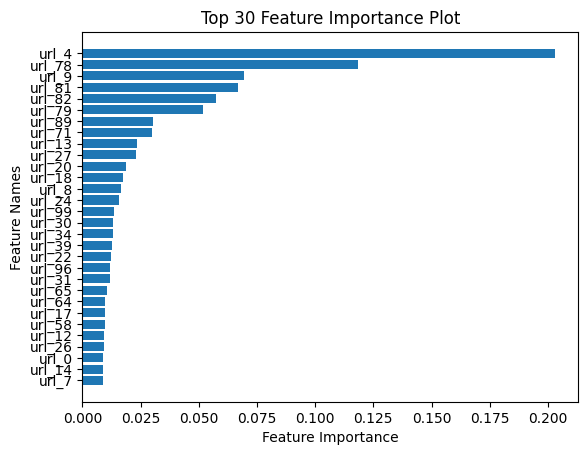

In [ ]:
import matplotlib.pyplot as plt

# 特徴量とその重要度を一緒に取得
features = list(X_URL_only.columns)
importances = model.feature_importances_

# 重要度に基づいて特徴量と重要度を一緒にソート
indices = np.argsort(importances)

# トップ20の特徴量とその重要度を取得
top_features = np.array(features)[indices][-30:]
top_importances = importances[indices][-30:]

# 重要度が高い特徴量から低い特徴量への順でプロット
plt.barh(top_features, top_importances)

# グラフのラベルとタイトルを設定
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Top 30 Feature Importance Plot')

# グラフを表示
plt.show()


## "url_" で始まる列を除いたすべての特徴を使用して学習するコード

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import metrics
import time

# "url_" で始まる列を除いたすべての特徴を使用
non_URL_columns = [col for col in processed_X.columns if not col.startswith('url_')]
X_without_URL = processed_X[non_URL_columns]

X_train, X_test, y_train, y_test = train_test_split(X_without_URL, y, test_size=0.3)
model = XGBClassifier(n_estimators=10)

start_time = time.time()
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

loss = metrics.log_loss(y_test, y_pred_proba)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='binary')
recall = metrics.recall_score(y_test, y_pred, average='binary')

print(f'Loss: {loss}, Accuracy: {accuracy:.3f}, Precision: {precision:.5f}, Recall: {recall:.5f}')
end_time = time.time()
print(f'学習時間:  {end_time - start_time} seconds')


[0]	validation_0-logloss:0.50586
[1]	validation_0-logloss:0.40545
[2]	validation_0-logloss:0.33674
[3]	validation_0-logloss:0.29465
[4]	validation_0-logloss:0.25797
[5]	validation_0-logloss:0.23205
[6]	validation_0-logloss:0.21547
[7]	validation_0-logloss:0.20175
[8]	validation_0-logloss:0.19355
[9]	validation_0-logloss:0.19159
Loss: 0.19159444451848945, Accuracy: 0.925, Precision: 0.78947, Recall: 0.57692
学習時間:  1.1268982887268066 seconds


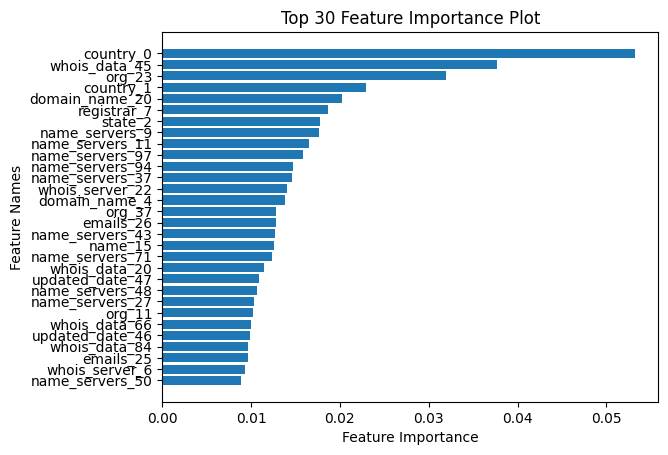

In [ ]:
import matplotlib.pyplot as plt

# 特徴量とその重要度を一緒に取得
features = list(X_without_URL.columns)
importances = model.feature_importances_

# 重要度に基づいて特徴量と重要度を一緒にソート
indices = np.argsort(importances)

# トップ20の特徴量とその重要度を取得
top_features = np.array(features)[indices][-30:]
top_importances = importances[indices][-30:]

# 重要度が高い特徴量から低い特徴量への順でプロット
plt.barh(top_features, top_importances)

# グラフのラベルとタイトルを設定
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Top 30 Feature Importance Plot')

# グラフを表示
plt.show()

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 3.7 MB/s eta 0:00:00


# SHAPによる解釈

In [ ]:
import shap

# 1. モデル shap.Explainer()に渡す
explainer = shap.Explainer(model)

# 2. 説明変数(特徴量)を渡す
shap_values = explainer(processed_X)
# shap_values = explainer(X_without_URL)

waterfallプロット  
予測に対する説明変数の寄与度を各データごとに確認できる  
$E[f(x)]$：訓練データに対するモデルの予測結果の平均値
$f(x)$：平均から予測結果$f(x)$までの寄与度

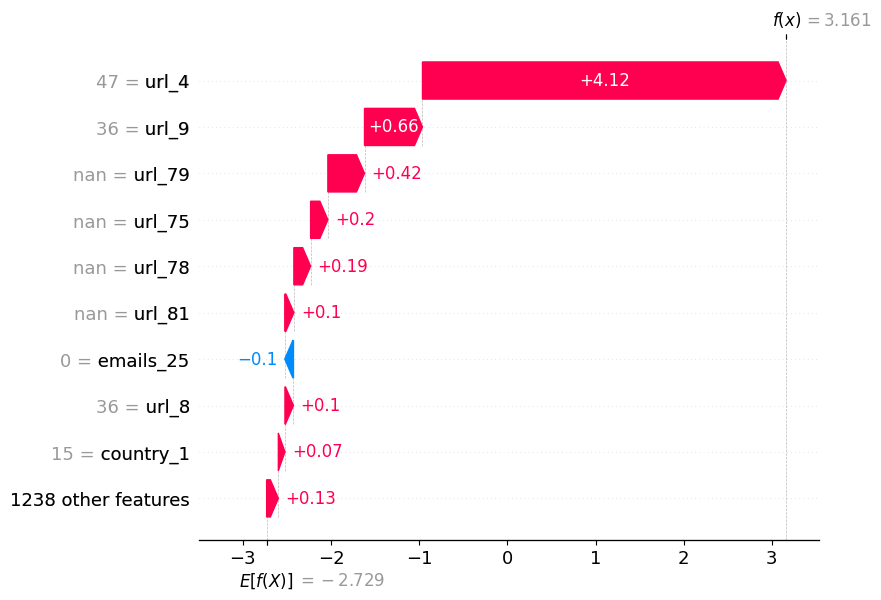

url_0         17.0
url_1         18.0
url_2         18.0
url_3          1.0
url_4         47.0
              ... 
country_15     NaN
country_16     NaN
country_17     NaN
country_18     NaN
country_19     NaN
Name: 111, Length: 1247, dtype: float64


In [ ]:
shap.plots.waterfall(shap_values[111])  # 1番目のデータを描画
print(processed_X.iloc[111])

beeswarmプロット

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


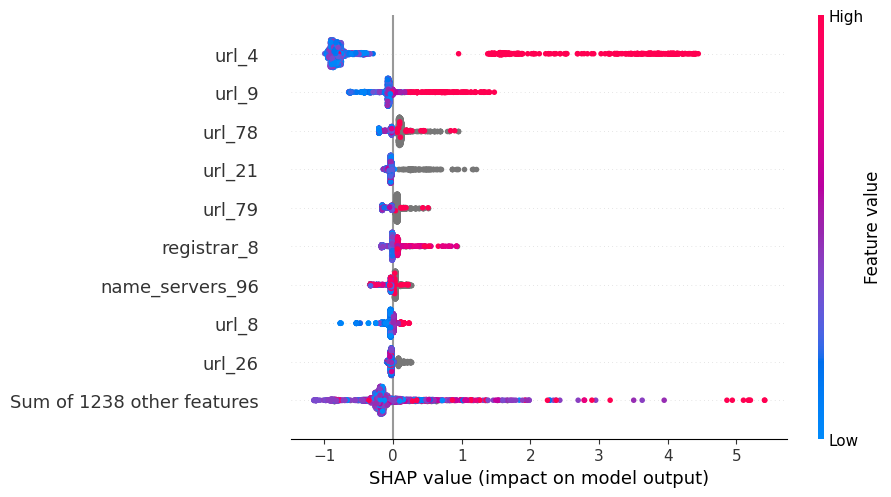

In [ ]:
shap.plots.beeswarm(shap_values)

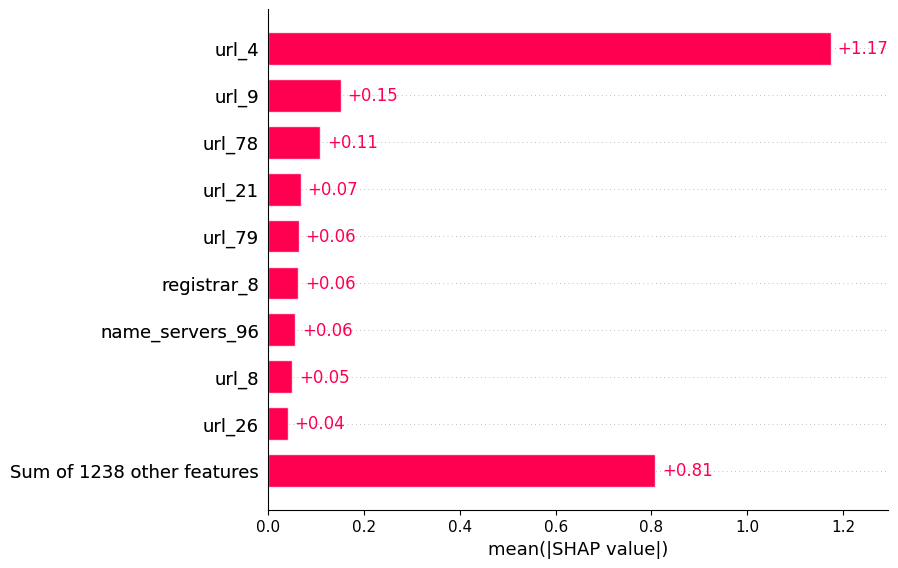

In [ ]:
shap.plots.bar(shap_values)

scatterプロット

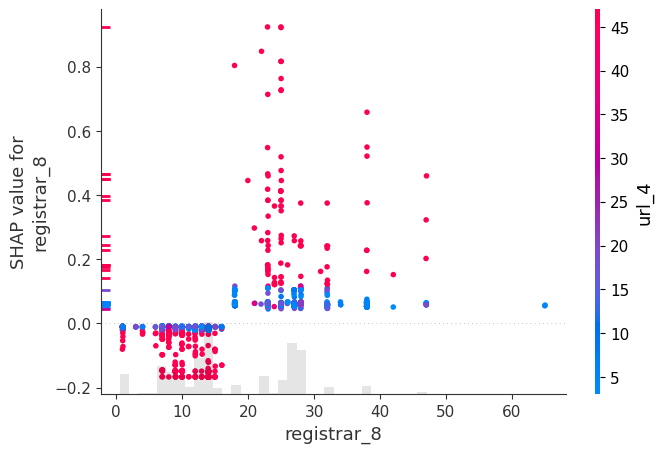

In [ ]:
shap.plots.scatter(shap_values[:, 'registrar_8'], color=shap_values)
# shap.plots.scatter(shap_values[:, 'whois_server_22'], color=shap_values)